**Aluno:** Alexandre Esposte Santos

**Data:** 23/10/2023

**Atividade:** Tarefa 4 - Project 2

# **Importando pacotes**

In [80]:
import numpy                 as np
import pandas                as pd
import matplotlib.pyplot     as plt
import seaborn               as sns


from sklearn.metrics 	     import mean_absolute_error, mean_squared_error
from sklearn.compose 	     import ColumnTransformer
from sklearn.pipeline 	     import Pipeline
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV
from sklearn.preprocessing   import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.impute          import KNNImputer

from sklearn.linear_model    import LinearRegression, Ridge, Lasso
from sklearn.svm             import SVR
from sklearn.tree            import DecisionTreeRegressor
from sklearn.ensemble        import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor,HistGradientBoostingRegressor,StackingRegressor
from xgboost                 import XGBRegressor
from lightgbm                import LGBMRegressor
from catboost                import CatBoostRegressor
from sklearn.dummy           import DummyRegressor
from sklearn.neighbors       import KNeighborsRegressor

from sklearn.feature_selection import SelectKBest, f_regression
from category_encoders.target_encoder import TargetEncoder

from feature_engine.creation import CyclicalFeatures

import joblib

# **Classe**

In [2]:
class ModelCrafter:

    def __init__(self) -> None:
        
        self.models = dict()

        self.results = dict()

        self.results_per_fold = dict()

        self.kf = KFold(n_splits=5) 

    def AddModel(self, modelos : list = []) -> None:
        """Método para adicionar modelos ao objeto. A estrutura é uma lista de tuplas onde a tupla segue o seguinte esquema: (nome do modelo, modelo instanciado)"""
        
        for modelo in modelos:
            self.models[modelo[0]] = modelo[1]

    def RemoveModel(self, nome: str = None, tipo: str = None) -> None:
        """Remove modelos do objeto"""
        
        if tipo == 'all':
            self.models=dict()
            return

        del self.models[nome]

          
    def HoldOut(self,X: pd.DataFrame, y: pd.Series, pipe: Pipeline ,nome: str):
        """Treina somente um modelo dentre os que estão no objeto"""
        if nome not in self.models.keys():
            print('Modelo invalido')
            return
        
        if len(pipe.steps) > 1:
            pipe.steps.pop()
            
        pipe.steps.append((nome,self.models[nome]))

        modelo = pipe

        x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

        modelo.fit(x_train,y_train)
        predito = modelo.predict(x_test)

        aux_df = x_test.copy()
    

        return predito, y_test, aux_df

    def Validacao(self, X_train: pd.DataFrame = None, X_test: pd.DataFrame = None , y_train: pd.Series = None, y_test: pd.Series = None, pipe: Pipeline = None):
       
        if len(self.models) == 0:
            return "Nenhum modelo adicionado na estrutura"

        resultados = {'modelo':[],'mae_treino':[], 'mae_teste':[], 'rms_treino':[], 'rms_teste':[]}

        for aux in self.models.items():
            nome_modelo = aux[0]
            modelo = aux[1]

            if len(pipe.steps) > 1:
                pipe.steps.pop()

            
            print(f"-----{nome_modelo}-----")
            pipe.steps.append(("Model",modelo))
            modelo = pipe

            modelo.fit(X_train,y_train)

            pred_train = modelo.predict(X_train)
            pred_test = modelo.predict(X_test)


            mae_train  =  mean_absolute_error(y_train,pred_train)
            rms_train =  mean_squared_error(y_train,pred_train, squared = False)

            mae_test = mean_absolute_error(y_test,pred_test)
            rms_test = mean_squared_error(y_test, pred_test, squared= False)

            resultados['modelo'].append(nome_modelo)
            resultados['mae_treino'].append(mae_train)
            resultados['mae_teste'].append(mae_test)
            resultados['rms_treino'].append(rms_train)
            resultados['rms_teste'].append(rms_test)

        return pd.DataFrame(resultados)
        

    def ValidacaoCruzada(self, X: np.ndarray, y: np.array, pipe: Pipeline = None, transform: bool = False) -> None:
        """Treina todos os modelos inseridos no objeto através de validação cruzada"""
		
        """Treina todos os modelos inseridos no objeto através de validação cruzada"""
		
        if len(self.models) == 0:
            return "Nenhum modelo adicionado na estrutura"


        for aux in self.models.items():
            nome_modelo = aux[0]
            modelo = aux[1]

            if len(pipe.steps) > 1:
                pipe.steps.pop()

            mae = 0
            rmse = 0

            resultados_aux = []

            print(f"-----{nome_modelo}-----")
            pipe.steps.append(("Model",modelo))
            modelo = pipe
            for i, (train_index, test_index) in enumerate(self.kf.split(X)):
                #print(f"Fold {i}:")
                
                #print(f"  Train: index={train_index}")
                #print(f"  Test:  index={test_index}")

                X_train = X.loc[train_index,:]
                y_train = y.loc[train_index]

                
                X_test = X.loc[test_index,:]
                y_test = y.loc[test_index]


                if transform:
                    y_train = y_train**0.5
                    

                
                modelo.fit(X_train,y_train)

                predito = modelo.predict(X_test)
                
                if transform:
                    predito = predito**2
                    
                
                
                resultados_aux.append((y_test,predito)) 
                
                mae  += mean_absolute_error(y_test,predito)
                rmse += mean_squared_error(y_test,predito,squared=True)

            self.results[nome_modelo]=[mae/5, rmse/5]
            self.results_per_fold[nome_modelo] = resultados_aux

        return self._gerar_resultado()

    def _gerar_resultado(self) -> None:
        """Gera os resultados em uma estrutura DataFrame"""
        
        indices = ['mae','rms']
        #display(pd.DataFrame(self.results,index=indices).T)
        return pd.DataFrame(self.results,index=indices).T

# **Carregando dados**

In [3]:
materials_raw = pd.read_csv('../datasets/project2/dataset_full.csv')

production = pd.read_csv('../datasets/project2/dataset_producao.csv')

In [4]:
materials_raw.head()

,Material,Space group,Crystal Type,Band gap,stoichiometry,media_Z,media_pon_Z,max_Z,min_Z,desvio_Z,...,max_NumberUnfilledOrbitals,min_NumberUnfilledOrbitals,desvio_NumberUnfilledOrbitals,desvio_pon_NumberUnfilledOrbitals,media_Polarizability,media_pon_Polarizability,max_Polarizability,min_Polarizability,desvio_Polarizability,desvio_pon_Polarizability
0,Be4,Pbcm,A-57-d,0.000000,A,4.0,4.000000,4,4,0.0,...,0.0,0.0,0.0,0.000000,37.710,37.710,37.71,37.71,0.000,0.000000
1,AlTe4,Cm,AB4-8-a,0.000000,AB4,32.5,44.200000,52,13,19.5,...,5.0,2.0,1.5,1.749286,46.200,40.680,55.40,37.00,9.200,10.728951
2,As4O6,P2_1,A2B3-4-a,3.876239,A2B3,20.5,18.000000,33,8,12.5,...,3.0,2.0,0.5,0.509902,17.520,15.064,29.80,5.24,12.280,12.523192
3,As4S6,Pc,A2B3-7-a,2.271995,A2B3,24.5,22.800000,33,16,8.5,...,3.0,2.0,0.5,0.509902,24.585,23.542,29.80,19.37,5.215,5.318277
4,B2N,P-3m1,AB2-164-bd,0.000000,AB2,6.0,5.666667,7,5,1.0,...,5.0,3.0,1.0,1.054093,14.065,16.220,20.53,7.60,6.465,6.814708


In [5]:
production.head()

,Material,Prototype,media_Z,media_pon_Z,max_Z,min_Z,desvio_Z,desvio_pon_Z,media_Electronegativity,media_pon_Electronegativity,...,max_NumberUnfilledOrbitals,min_NumberUnfilledOrbitals,desvio_NumberUnfilledOrbitals,desvio_pon_NumberUnfilledOrbitals,media_Polarizability,media_pon_Polarizability,max_Polarizability,min_Polarizability,desvio_Polarizability,desvio_pon_Polarizability
0,Sc2F3,P-3m1,15.0,13.8,21,9,6.0,6.118823,2.67,2.932,...,9.0,1.0,4.0,4.079216,55.350,45.020,107.0,3.70,51.650,52.672872
1,Sc2F3,P-6m2,15.0,13.8,21,9,6.0,6.118823,2.67,2.932,...,9.0,1.0,4.0,4.079216,55.350,45.020,107.0,3.70,51.650,52.672872
2,Sc2F3,Pmmn,15.0,13.8,21,9,6.0,6.118823,2.67,2.932,...,9.0,1.0,4.0,4.079216,55.350,45.020,107.0,3.70,51.650,52.672872
3,Sc2F3,P1,15.0,13.8,21,9,6.0,6.118823,2.67,2.932,...,9.0,1.0,4.0,4.079216,55.350,45.020,107.0,3.70,51.650,52.672872
4,Sc2Cl3,P-3m1,19.0,18.6,21,17,2.0,2.039608,2.26,2.440,...,9.0,1.0,4.0,4.079216,60.785,51.542,107.0,14.57,46.215,47.130237


# **Tratamentos**

Vamos realizar algumas tratativas prévias antes mesmo de analisar os dados e treinar os modelos.

In [6]:
# Renomeando a coluna prototype para space group
production = production.rename({'Prototype':'Space group'},axis=1)
production

,Material,Space group,media_Z,media_pon_Z,max_Z,min_Z,desvio_Z,desvio_pon_Z,media_Electronegativity,media_pon_Electronegativity,...,max_NumberUnfilledOrbitals,min_NumberUnfilledOrbitals,desvio_NumberUnfilledOrbitals,desvio_pon_NumberUnfilledOrbitals,media_Polarizability,media_pon_Polarizability,max_Polarizability,min_Polarizability,desvio_Polarizability,desvio_pon_Polarizability
0,Sc2F3,P-3m1,15.0,13.8,21,9,6.0,6.118823,2.67,2.932,...,9.0,1.0,4.0,4.079216,55.350,45.020,107.0,3.70,51.650,52.672872
1,Sc2F3,P-6m2,15.0,13.8,21,9,6.0,6.118823,2.67,2.932,...,9.0,1.0,4.0,4.079216,55.350,45.020,107.0,3.70,51.650,52.672872
2,Sc2F3,Pmmn,15.0,13.8,21,9,6.0,6.118823,2.67,2.932,...,9.0,1.0,4.0,4.079216,55.350,45.020,107.0,3.70,51.650,52.672872
3,Sc2F3,P1,15.0,13.8,21,9,6.0,6.118823,2.67,2.932,...,9.0,1.0,4.0,4.079216,55.350,45.020,107.0,3.70,51.650,52.672872
4,Sc2Cl3,P-3m1,19.0,18.6,21,17,2.0,2.039608,2.26,2.440,...,9.0,1.0,4.0,4.079216,60.785,51.542,107.0,14.57,46.215,47.130237
5,Sc2Cl3,P-6m2,19.0,18.6,21,17,2.0,2.039608,2.26,2.440,...,9.0,1.0,4.0,4.079216,60.785,51.542,107.0,14.57,46.215,47.130237
6,Sc2Cl3,Pmmn,19.0,18.6,21,17,2.0,2.039608,2.26,2.440,...,9.0,1.0,4.0,4.079216,60.785,51.542,107.0,14.57,46.215,47.130237
7,Sc2Cl3,P1,19.0,18.6,21,17,2.0,2.039608,2.26,2.440,...,9.0,1.0,4.0,4.079216,60.785,51.542,107.0,14.57,46.215,47.130237
8,Ti2F3,P-3m1,15.5,14.2,22,9,6.5,6.628725,2.76,3.004,...,8.0,1.0,3.5,3.569314,47.850,39.020,92.0,3.70,44.150,45.024342
9,Ti2F3,P-6m2,15.5,14.2,22,9,6.5,6.628725,2.76,3.004,...,8.0,1.0,3.5,3.569314,47.850,39.020,92.0,3.70,44.150,45.024342


In [7]:
# Removendo as colunas stoichiometry e Crystal Type
materials_raw = materials_raw.drop(['stoichiometry','Crystal Type'],axis=1)

Agora as variáveis de ambos os datasets estão iguais. Exceto pelo target presente no materials_raw e ausente do production

In [8]:
print(f"# variáveis do dataset materials_raw: {materials_raw.shape[-1]}",
      f"\n# variáveis do dataset production: {production.shape[-1]}")

# variáveis do dataset materials_raw: 105 
# variáveis do dataset production: 104


Verificando se os space group do dataset production estão presentes também no material_raw.

**R:** Todos estão presentes em ambos os datasets. Não será necessário realizar nenhum tratamento com relação a isso.

In [9]:
for space in production['Space group'].tolist():
    
    if space in materials_raw['Space group'].unique():
        print(f"{space} está presente em ambos")
    else:
        print(f"-->{space} não está presente em ambos<--")
    

P-3m1 está presente em ambos
P-6m2 está presente em ambos
Pmmn está presente em ambos
P1 está presente em ambos
P-3m1 está presente em ambos
P-6m2 está presente em ambos
Pmmn está presente em ambos
P1 está presente em ambos
P-3m1 está presente em ambos
P-6m2 está presente em ambos
Pmmn está presente em ambos
P1 está presente em ambos
P-3m1 está presente em ambos
P-6m2 está presente em ambos
Pmmn está presente em ambos
P1 está presente em ambos


**Verificando missing values**

**R:** Foi encontrado 1532 valores faltantes

In [10]:
materials_raw.isna().sum().sum()

1532

In [11]:
# Features com valores faltantes
materials_raw.isna().sum().to_frame(name='# faltantes').sort_values(by = '# faltantes',ascending=False).head(20)

,# faltantes
media_pon_r_d_orbital,189
media_r_d_orbital,189
media_r_p_orbital,189
media_pon_r_p_orbital,189
desvio_pon_r_d_orbital,189
desvio_r_d_orbital,189
desvio_r_p_orbital,189
desvio_pon_r_p_orbital,189
max_r_p_orbital,4
min_r_p_orbital,4


**Verificando valores duplicados**

**R:** Foram identificados 50 instâncias duplicadas

In [12]:
materials_raw.duplicated().sum()

50

A seguir os materiais duplicados

In [13]:
idx = materials_raw.duplicated().to_frame(name='duplicado').query(' duplicado == True').index

materials_raw.iloc[idx,:]

,Material,Space group,Band gap,media_Z,media_pon_Z,max_Z,min_Z,desvio_Z,desvio_pon_Z,media_Electronegativity,...,max_NumberUnfilledOrbitals,min_NumberUnfilledOrbitals,desvio_NumberUnfilledOrbitals,desvio_pon_NumberUnfilledOrbitals,media_Polarizability,media_pon_Polarizability,max_Polarizability,min_Polarizability,desvio_Polarizability,desvio_pon_Polarizability
971,Ca2Cl2,P4/nmm,0.0,18.500000,18.500000,20,17,1.500000,1.500000,2.080000,...,1.0,0.0,0.500000,0.500000,87.670000,87.670000,160.77,14.57,73.100000,73.100000
1062,Pd2Se2,C2/m,0.0,40.000000,40.000000,46,34,6.000000,6.000000,2.375000,...,2.0,0.0,1.000000,1.000000,29.120000,29.120000,32.00,26.24,2.880000,2.880000
1439,BiMoAs,P3m1,0.0,52.666667,52.666667,83,33,21.761332,21.761332,2.120000,...,6.0,3.0,1.414214,1.414214,55.266667,55.266667,86.00,29.80,23.243828,23.243828
1440,BiTaAs,P3m1,0.0,63.000000,63.000000,83,33,21.602469,21.602469,1.900000,...,7.0,3.0,1.885618,1.885618,55.933333,55.933333,88.00,29.80,24.127624,24.127624
1441,BiVAs,P3m1,0.0,46.333333,46.333333,83,23,26.246693,26.246693,1.943333,...,7.0,3.0,1.885618,1.885618,53.600000,53.600000,81.00,29.80,21.056749,21.056749
1442,BiZrAs,P3m1,0.0,52.000000,52.000000,83,33,22.105806,22.105806,1.843333,...,8.0,3.0,2.357023,2.357023,66.933333,66.933333,121.00,29.80,39.110215,39.110215
1448,MoAsSb,P3m1,0.0,42.000000,42.000000,51,33,7.348469,7.348469,2.130000,...,6.0,3.0,1.414214,1.414214,52.783333,52.783333,86.00,29.80,24.057581,24.057581
1460,BiHfSb,P3m1,0.0,68.666667,68.666667,83,51,13.274872,13.274872,1.790000,...,8.0,3.0,2.357023,2.357023,67.183333,67.183333,109.00,42.55,29.724859,29.724859
1463,BiMoSb,P3m1,0.0,58.666667,58.666667,83,42,17.594191,17.594191,2.076667,...,6.0,3.0,1.414214,1.414214,59.516667,59.516667,86.00,42.55,18.971924,18.971924
1464,BiTaSb,P3m1,0.0,69.000000,69.000000,83,51,13.366625,13.366625,1.856667,...,7.0,3.0,1.885618,1.885618,60.183333,60.183333,88.00,42.55,19.903113,19.903113


Como exemplo eu peguei o material "Pd2Te2". Observamos que as instâncias de índice 270 e 1872 são iguais.

In [14]:
materials_raw.query('Material == "Pd2Te2"')

,Material,Space group,Band gap,media_Z,media_pon_Z,max_Z,min_Z,desvio_Z,desvio_pon_Z,media_Electronegativity,...,max_NumberUnfilledOrbitals,min_NumberUnfilledOrbitals,desvio_NumberUnfilledOrbitals,desvio_pon_NumberUnfilledOrbitals,media_Polarizability,media_pon_Polarizability,max_Polarizability,min_Polarizability,desvio_Polarizability,desvio_pon_Polarizability
270,Pd2Te2,C2/m,0.0,49.0,49.0,52,46,3.0,3.0,2.15,...,2.0,0.0,1.0,1.0,34.5,34.5,37.0,32.0,2.5,2.5
1872,Pd2Te2,C2/m,0.0,49.0,49.0,52,46,3.0,3.0,2.15,...,2.0,0.0,1.0,1.0,34.5,34.5,37.0,32.0,2.5,2.5
2690,Pd2Te2,P-6m2,0.0,49.0,49.0,52,46,3.0,3.0,2.15,...,2.0,0.0,1.0,1.0,34.5,34.5,37.0,32.0,2.5,2.5


Removendo os valores duplicados.

In [15]:
print(f"# instâncias do dataset materials_raw antes: {materials_raw.shape[0]}")
materials_raw = materials_raw.drop_duplicates()

print(f"# instâncias do dataset materials_raw depois: {materials_raw.shape[0]}")

# instâncias do dataset materials_raw antes: 3227
# instâncias do dataset materials_raw depois: 3177


Vamos remover todos os materiais com gap igual a zero conforme solicitado no pdf

In [16]:
materials_raw.columns

Index(['Material', 'Space group', 'Band gap', 'media_Z', 'media_pon_Z',
       'max_Z', 'min_Z', 'desvio_Z', 'desvio_pon_Z', 'media_Electronegativity',
       ...
       'max_NumberUnfilledOrbitals', 'min_NumberUnfilledOrbitals',
       'desvio_NumberUnfilledOrbitals', 'desvio_pon_NumberUnfilledOrbitals',
       'media_Polarizability', 'media_pon_Polarizability',
       'max_Polarizability', 'min_Polarizability', 'desvio_Polarizability',
       'desvio_pon_Polarizability'],
      dtype='object', length=105)

In [17]:
idx = materials_raw[materials_raw['Band gap'] == 0].index

print(f"Quantidade de metais: {len(idx)}")
print(f"# instâncias do dataset materials_raw antes: {materials_raw.shape[0]}")
materials = materials_raw.drop(idx)
print(f"# instâncias do dataset materials_raw depois: {materials.shape[0]}")


Quantidade de metais: 1911
# instâncias do dataset materials_raw antes: 3177
# instâncias do dataset materials_raw depois: 1266


Finalizamos por aqui alguns tratamentos necessário para o desenvolvimento de um modelo.

# **Análise**

Vamos realizar uma breve EDA para entendermos um pouco sobre os nossos dados

**1. Quantidade de materiais**

R: Há 1026 materiais

In [18]:
materials['Material'].nunique()

1026

Apesar de serem 1026 materiais, observamos que a estrutura  "atômica/molecular" se repete algumas vezes. Como exemplo notamos que há quatro instâncias do material com fórmula Pb2Te2. Provavelmente a estrutura espacial se altera de uma instância para a outra 

In [19]:
materials['Material'].value_counts().to_frame(name='Material_qte')

,Material_qte
Pb2Te2,4
Cl2Ge,3
ZrS2,3
Zr2Br2N2,3
HgI2,3
...,...
W2O2,1
PbSe,1
Pt2S2,1
Rh2Se2,1


A seguir um exemplo onde notamos que o Space Group é diferente para cada instância com uma mesma fórmula

In [20]:
materials.query("Material == 'Pb2Te2'")

,Material,Space group,Band gap,media_Z,media_pon_Z,max_Z,min_Z,desvio_Z,desvio_pon_Z,media_Electronegativity,...,max_NumberUnfilledOrbitals,min_NumberUnfilledOrbitals,desvio_NumberUnfilledOrbitals,desvio_pon_NumberUnfilledOrbitals,media_Polarizability,media_pon_Polarizability,max_Polarizability,min_Polarizability,desvio_Polarizability,desvio_pon_Polarizability
1060,Pb2Te2,P4/mmm,0.271210,67.0,67.0,82,52,15.0,15.0,2.215,...,4.0,2.0,1.0,1.0,42.355,42.355,47.71,37.0,5.355,5.355
1869,Pb2Te2,P4/nmm,0.050055,67.0,67.0,82,52,15.0,15.0,2.215,...,4.0,2.0,1.0,1.0,42.355,42.355,47.71,37.0,5.355,5.355
1870,Pb2Te2,Pmn2_1,0.445387,67.0,67.0,82,52,15.0,15.0,2.215,...,4.0,2.0,1.0,1.0,42.355,42.355,47.71,37.0,5.355,5.355
2687,Pb2Te2,P-1,0.434072,67.0,67.0,82,52,15.0,15.0,2.215,...,4.0,2.0,1.0,1.0,42.355,42.355,47.71,37.0,5.355,5.355


In [21]:
materials.query("Material == 'Cl2Ge'")

,Material,Space group,Band gap,media_Z,media_pon_Z,max_Z,min_Z,desvio_Z,desvio_pon_Z,media_Electronegativity,...,max_NumberUnfilledOrbitals,min_NumberUnfilledOrbitals,desvio_NumberUnfilledOrbitals,desvio_pon_NumberUnfilledOrbitals,media_Polarizability,media_pon_Polarizability,max_Polarizability,min_Polarizability,desvio_Polarizability,desvio_pon_Polarizability
359,Cl2Ge,P-3m1,2.617476,24.5,22.0,32,17,7.5,7.905694,2.585,...,4.0,1.0,1.5,1.581139,27.0,22.856667,39.43,14.57,12.43,13.10237
1156,Cl2Ge,P-6m2,2.954808,24.5,22.0,32,17,7.5,7.905694,2.585,...,4.0,1.0,1.5,1.581139,27.0,22.856667,39.43,14.57,12.43,13.10237
2781,Cl2Ge,P-4m2,1.373038,24.5,22.0,32,17,7.5,7.905694,2.585,...,4.0,1.0,1.5,1.581139,27.0,22.856667,39.43,14.57,12.43,13.10237


**2. Space Group**

Há 50 configurações espaciais

In [22]:
materials['Space group'].nunique()

50

Além disso, observamos que não há homogeneidade na configuração espacial. Tendo muito mais configurações P1 do que as demais.

As configurações mais "raras" **pode ser** um problema para o nosso modelo.

In [23]:
materials['Space group'].value_counts().to_frame()

,Space group
P1,198
P-3m1,129
P3m1,123
P-6m2,121
P-1,93
Pmmn,84
P-4m2,65
P4/nmm,49
P2_1/m,47
C2/m,46


**3. Disitribuição do Band gap (target)**

O gap apresenta uma distribuição assimétrica a direita com alguns possíveis outliers presentes.

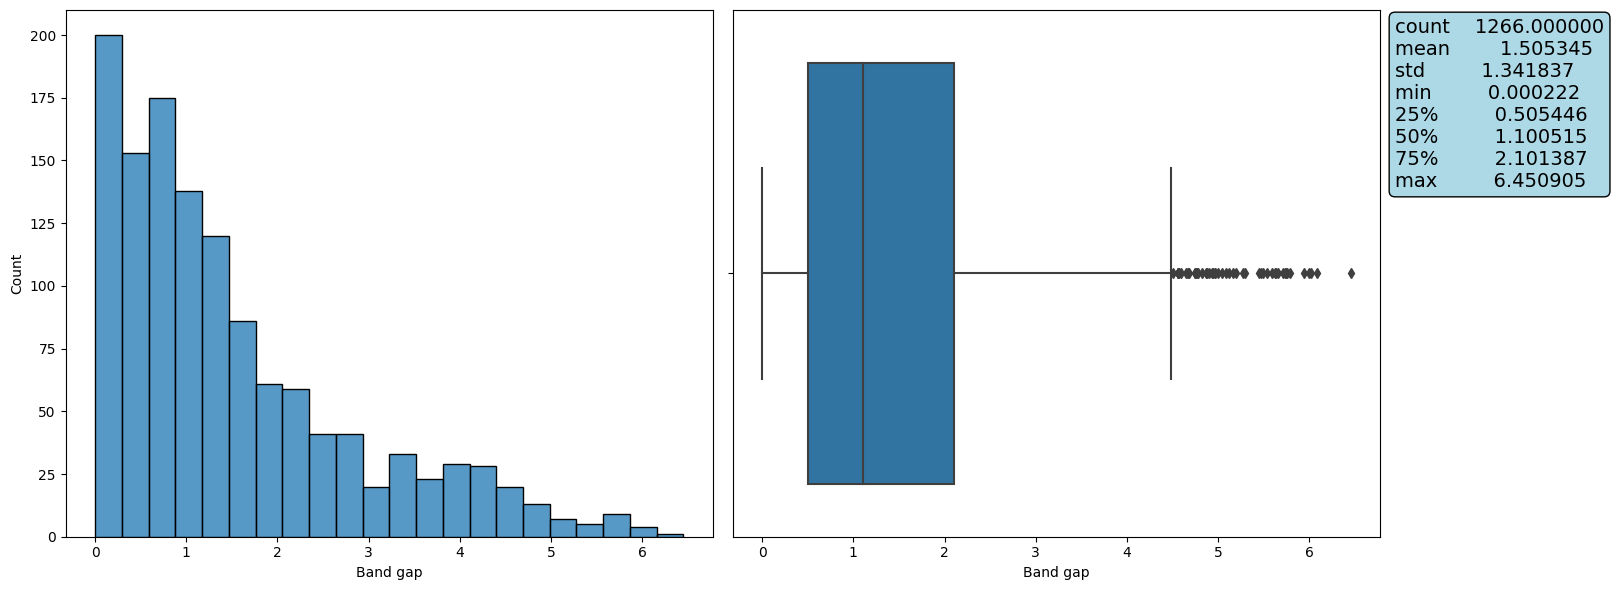

In [24]:
fig, ax = plt.subplots(1,2,figsize=(14,6))
sns.histplot(data=materials,x='Band gap',ax=ax[0])

sns.boxplot(data=materials,x='Band gap',ax=ax[1])


describe = materials['Band gap'].describe().to_string()
fig.text(1,0.68,describe,fontsize=14, color='black'  , bbox={'facecolor':(173/255, 216/255, 230/255), 'edgecolor':'black','boxstyle':'round'})

plt.tight_layout()

# **Modelagem**

Os critérios de avaliação serão utilizados pelas métricas citadas a seguir:

* **Erro médio absoluto (MAE)**
* **Raiz do erro médio quadrático (RMSE)**
* **Análise de erro**

Buscamos o modelo com os menores erros médios.

In [25]:
X = materials.drop(['Material','Band gap'],axis=1)
y = materials['Band gap']

In [26]:
# Separando as features categoricas
categoricas = X.select_dtypes(include=['object']).columns

# Separando as features numéricas
numericas = X.select_dtypes(exclude=['object']).columns

print(f"Categoricas: {categoricas}\n\nNuméricas: {numericas}")

Categoricas: Index(['Space group'], dtype='object')

Numéricas: Index(['media_Z', 'media_pon_Z', 'max_Z', 'min_Z', 'desvio_Z', 'desvio_pon_Z',
       'media_Electronegativity', 'media_pon_Electronegativity',
       'max_Electronegativity', 'min_Electronegativity',
       ...
       'max_NumberUnfilledOrbitals', 'min_NumberUnfilledOrbitals',
       'desvio_NumberUnfilledOrbitals', 'desvio_pon_NumberUnfilledOrbitals',
       'media_Polarizability', 'media_pon_Polarizability',
       'max_Polarizability', 'min_Polarizability', 'desvio_Polarizability',
       'desvio_pon_Polarizability'],
      dtype='object', length=102)


**Vamos dividir em treino e teste na proporção 80/20.**

In [27]:
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2, shuffle=True ,random_state= 42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

**Instanciando o objeto modelcrafter**

In [28]:
modelcrafter = ModelCrafter()
modelcrafter

**Estabelecendo os modelos**

In [29]:
modelos = [('regressao linear',LinearRegression()),
           ('lasso',Lasso()),
           ('ridge',Ridge()),
           ('svr',SVR()),
           ('arvore',DecisionTreeRegressor(random_state = 42)),
           ('floresta',RandomForestRegressor(random_state = 42,n_jobs=-1)),
           ('adaboost',AdaBoostRegressor(random_state= 42)),
           ('gradientboosting',GradientBoostingRegressor(random_state=42)),
           ('xgb',XGBRegressor()),
           ('lgbm',LGBMRegressor()),
           ('catboost',CatBoostRegressor(verbose=0)),
           ('hist',HistGradientBoostingRegressor()),
           ('knn',KNeighborsRegressor()),
           ('dummy',DummyRegressor())]

**Adicionando os modelos na estrutura**

In [30]:
modelcrafter.AddModel(modelos = modelos)
modelcrafter.models

{'regressao linear': LinearRegression(),
 'lasso': Lasso(),
 'ridge': Ridge(),
 'svr': SVR(),
 'arvore': DecisionTreeRegressor(random_state=42),
 'floresta': RandomForestRegressor(n_jobs=-1, random_state=42),
 'adaboost': AdaBoostRegressor(random_state=42),
 'gradientboosting': GradientBoostingRegressor(random_state=42),
 'xgb': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=No

**Desenvolvendo a pipeline de pré processamento**

In [31]:
numerical_transform = Pipeline([('imputer',KNNImputer()), 
                                ("scaler",StandardScaler())])

categorical_transform = Pipeline([('encoder',TargetEncoder()), 
                                  ('imputer',KNNImputer()),
                                  ('scaler',StandardScaler())])

preprocessor = ColumnTransformer([('categorical',categorical_transform, categoricas), 
                                  ('numeric', numerical_transform,numericas)],
                                remainder='passthrough')


model_pipeline = Pipeline([('preprocessor',preprocessor)])

model_pipeline.set_output(transform='pandas')


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder()),
                                                                  ('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Space group'], dtype='object')),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['media_Z', 'media_pon_...
       'max_Electronegativity', 'min_Electronegativity',
       ...
       'max_NumberUnfilledOrbitals', 'min_NumberUnfilledOrbitals',
       'desvio_NumberUnfilledOrbitals', 'desvio_pon_NumberUnfilledOrbitals',
       'media_Polarizability', 'media_pon_Polarizability',
       'max_Polarizability', 'min_Polarizability', 'desvio_Polarizability',
       'desvio_pon_Polarizability'],
      dtype='object', length=102))]))])

**Obtendo uma baseline**

O catboost foi o nosso melhor modelo

In [32]:
baseline = modelcrafter.ValidacaoCruzada(X_train,y_train,model_pipeline)

baseline.sort_values(by='mae',ascending=True)

-----regressao linear-----
-----lasso-----
-----ridge-----
-----svr-----
-----arvore-----
-----floresta-----
-----adaboost-----
-----gradientboosting-----
-----xgb-----
-----lgbm-----
-----catboost-----
-----hist-----
-----knn-----
-----dummy-----


,mae,rms
catboost,0.453817,0.408763
hist,0.475905,0.455620
lgbm,0.479702,0.459147
xgb,0.486153,0.488567
floresta,0.492131,0.472335
gradientboosting,0.496724,0.473094
svr,0.524862,0.541843
knn,0.576093,0.665725
ridge,0.594367,0.632320
regressao linear,0.604805,0.668968


Ao aplicarmos a raiz quadrada nos nossos dados nós observamos dados mais  simétricos.

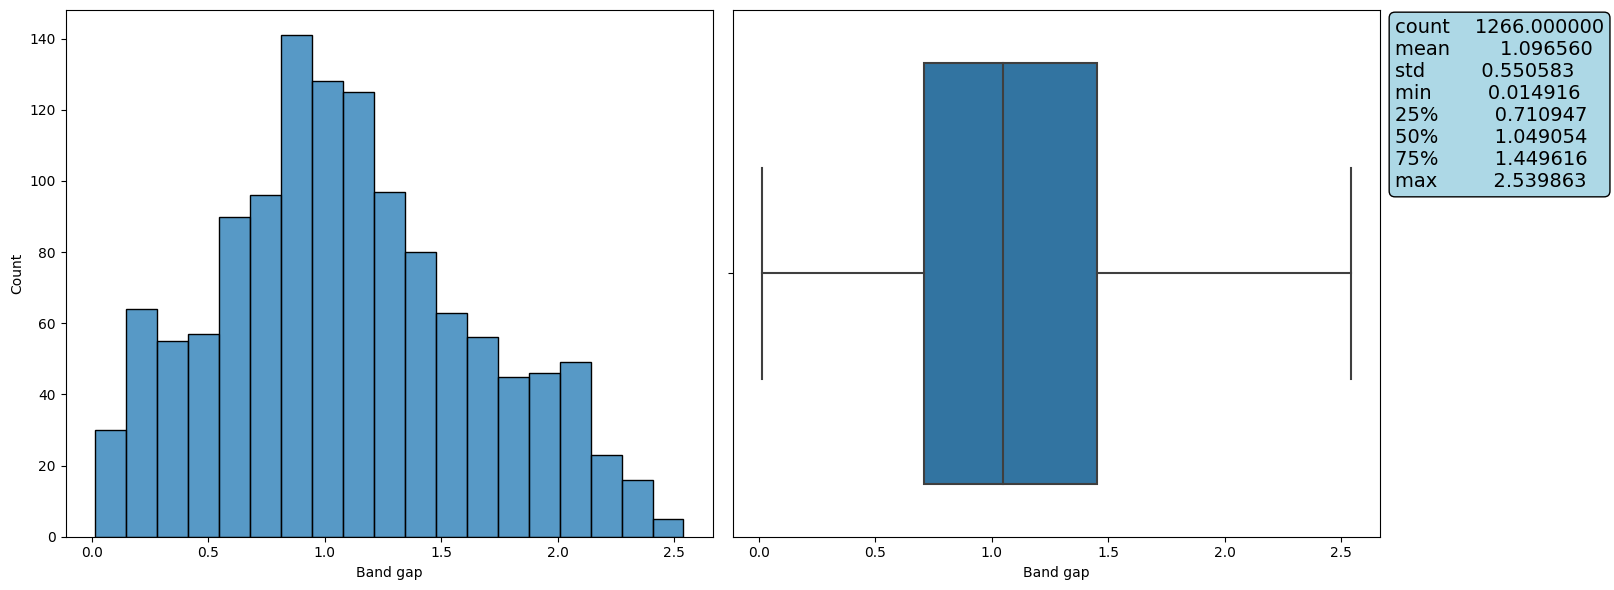

In [40]:
fig, ax = plt.subplots(1,2,figsize=(14,6))
sns.histplot(x=materials['Band gap']**0.5,ax=ax[0])

sns.boxplot(x=materials['Band gap']**0.5,ax=ax[1])


describe = (materials['Band gap']**0.5).describe().to_string()
fig.text(1,0.68,describe,fontsize=14, color='black'  , bbox={'facecolor':(173/255, 216/255, 230/255), 'edgecolor':'black','boxstyle':'round'})

plt.tight_layout()

 Vamos tentar aplicar essa transformação.

obs: Apesar de treinar os modelos com o $\sqrt{gap}$ , as métricas são calculadas com o gap. Dessa forma estaremos obtendo o erro na escala correta

**R:** Notamos uma pequena melhora, nada substâncial

In [34]:
com_transform = modelcrafter.ValidacaoCruzada(X_train,y_train,model_pipeline,transform=True)

com_transform.sort_values(by='mae',ascending=True)

-----regressao linear-----
-----lasso-----
-----ridge-----
-----svr-----
-----arvore-----
-----floresta-----
-----adaboost-----
-----gradientboosting-----
-----xgb-----
-----lgbm-----
-----catboost-----
-----hist-----
-----knn-----
-----dummy-----


,mae,rms
catboost,0.453136,0.416138
lgbm,0.463996,0.434343
hist,0.464076,0.425537
xgb,0.480338,0.474759
floresta,0.493638,0.493477
gradientboosting,0.499645,0.483888
svr,0.500664,0.492829
knn,0.574875,0.668259
ridge,0.583264,0.657863
regressao linear,0.600907,0.744727


Podemos alterar o pipeline e adicionar transformações polinomiais ou features de fourier  para vermos se há melhora neste caso.

Vamos treinar os modelos sem levar em consideração a raiz quadrada.

Além disso, vamos adicinar também o objeto selectKbest para selecionar as possíveis melhores 100 features.

In [35]:
numerical_transform = Pipeline([('imputer',KNNImputer()),
                                ('polynomial',PolynomialFeatures()),
                                ("scaler",StandardScaler())])

categorical_transform = Pipeline([('encoder',TargetEncoder()), 
                                  ('imputer',KNNImputer()),
                                  ('scaler',StandardScaler())])

preprocessor = ColumnTransformer([('categorical',categorical_transform, categoricas), 
                                  ('numeric', numerical_transform,numericas)],
                                remainder='passthrough')


model_pipeline = Pipeline([('preprocessor',preprocessor),
                           ('kbest',SelectKBest(score_func= f_regression,k=100))])

model_pipeline.set_output(transform='pandas')


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder()),
                                                                  ('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Space group'], dtype='object')),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('polynomial',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScal...
       'max_NumberUnfilledOrbitals', 'min_NumberUnfilledOrbitals',
       'desvio_NumberUnfilledOrbitals', 'desvio_pon_NumberUnfilledOrbitals',
       'media_Polarizability', 'media_pon_Polarizability',
       'max_Polarizability', 'min_Polarizability', 'desvio_Polarizability',
       'desvio_pon_Polarizability'],
      dtype='object', length=102))])),
                ('kbest', SelectKBest(k=100, score_func='f_regression'))])

Até o momento o CatBoostRegressor foi o nosso melhor modelo. Com uma queda de +- 11% do rmse e de +-4% do mae. A melhora do rmse indica que o modelo foi capaz estimar melhor os valores, diminuindo assim a penalização sobre os erros mais elevados.

In [36]:
com_polynomial = modelcrafter.ValidacaoCruzada(X_train,y_train,model_pipeline)

com_polynomial.sort_values(by='mae',ascending=True)

-----regressao linear-----
-----lasso-----
-----ridge-----
-----svr-----
-----arvore-----
-----floresta-----
-----adaboost-----
-----gradientboosting-----
-----xgb-----
-----lgbm-----
-----catboost-----
-----hist-----
-----knn-----
-----dummy-----


,mae,rms
catboost,4.349120e-01,3.788783e-01
lgbm,4.589991e-01,4.379259e-01
hist,4.636253e-01,4.419474e-01
gradientboosting,4.714451e-01,4.410527e-01
xgb,5.013322e-01,5.365768e-01
floresta,5.066646e-01,4.959176e-01
svr,5.502412e-01,5.843059e-01
knn,5.983808e-01,6.992305e-01
adaboost,6.000699e-01,5.743257e-01
ridge,6.453319e-01,1.026565e+00


Como dito antes, o nosso melhor modelo até então foi o CatBoostRegressor. Uma outra abordagem pode ser o desenvolvimento de outros modelos ensemble. Poderiamos criar um StackingRegressor, mas para isso precisariamos analisar os pontos fortes e fracos de cada modelo, dessa maneira poderiamos decidir quais modelos incluiríamos no ensemble.

Temos um porém, o catboost apesar de ter sido o melhor, não necessáriamente foi o mais rapido. Muito pelo contrário, foi o modelo mais demorado depois que incluímos as features polinomiais. Desse modo, realizar o tunning de hiperparâmetros levaria horas ou até mesmo dias. 

Logo, seria uma aventura tentar desenvolver um ensemble com o catboost e depois tunar toda essa estrutura.

Temos algumas opções:

1. Utilizar o catboost sem as features polinomiais. Isso no permitiria criar ensembles e realizar tunning com menor tempo. Existe a possibilidade dessas duas abordagens melhorarem as métricas.

2. Continuar com as features polinomiais e escolher outros modelos com as métricas piores mas mais rápidos para treinar.

Eu vou considerar o catboost obtido dessa ultimo treinamento. Entrentanto, não vou tuna-lo pois isso levaria boas horas. Vamos treinar os modelos e avaliar no conjunto de teste

In [41]:
results = modelcrafter.Validacao(X_train,X_test,y_train,y_test,model_pipeline)

results['mae_diff'] = results['mae_treino'] - results['mae_teste']
results['rms_diff'] = results['rms_treino'] - results['rms_teste']

-----regressao linear-----
-----lasso-----
-----ridge-----
-----svr-----
-----arvore-----
-----floresta-----
-----adaboost-----
-----gradientboosting-----
-----xgb-----
-----lgbm-----
-----catboost-----
-----hist-----
-----knn-----
-----dummy-----


In [65]:
results.sort_values(by='mae_diff').head()

,modelo,mae_treino,mae_teste,rms_treino,rms_teste,mae_diff,rms_diff,mae_cv,rms_cv
6,adaboost,0.525497,0.619496,0.618155,0.791505,-0.019426,-0.217179,0.600070,0.574326
7,gradientboosting,0.253697,0.490817,0.330156,0.700673,-0.019372,-0.259621,0.471445,0.441053
10,catboost,0.095255,0.454211,0.131160,0.680221,-0.019299,-0.301342,0.434912,0.378878
11,hist,0.068626,0.480937,0.124967,0.723168,-0.017311,-0.281220,0.463625,0.441947
9,lgbm,0.069111,0.474962,0.124579,0.721033,-0.015963,-0.283107,0.458999,0.437926


In [64]:
results.sort_values(by='rms_diff').head()

,modelo,mae_treino,mae_teste,rms_treino,rms_teste,mae_diff,rms_diff,mae_cv,rms_cv
10,catboost,0.095255,0.454211,0.131160,0.680221,-0.019299,-0.301342,0.434912,0.378878
9,lgbm,0.069111,0.474962,0.124579,0.721033,-0.015963,-0.283107,0.458999,0.437926
11,hist,0.068626,0.480937,0.124967,0.723168,-0.017311,-0.281220,0.463625,0.441947
7,gradientboosting,0.253697,0.490817,0.330156,0.700673,-0.019372,-0.259621,0.471445,0.441053
6,adaboost,0.525497,0.619496,0.618155,0.791505,-0.019426,-0.217179,0.600070,0.574326


In [54]:
com_polynomial = com_polynomial.reset_index(drop=True)
com_polynomial = com_polynomial.rename({'index':'modelo','mae':'mae_cv','rms':'rms_cv'},axis=1)

In [58]:
results = pd.merge(results,com_polynomial,on='modelo')

In [59]:
results['mae_diff'] = results['mae_cv'] - results['mae_teste']
results['rms_diff'] = results['rms_cv'] - results['rms_teste']

Vamos selecionar o Catboost como nosso modelo

In [81]:
best_model = modelcrafter.models['catboost']

numerical_transform = Pipeline([('imputer',KNNImputer()),
                                ('polynomial',PolynomialFeatures()),
                                ("scaler",StandardScaler())])

categorical_transform = Pipeline([('encoder',TargetEncoder()), 
                                  ('imputer',KNNImputer()),
                                  ('scaler',StandardScaler())])

preprocessor = ColumnTransformer([('categorical',categorical_transform, categoricas), 
                                  ('numeric', numerical_transform,numericas)],
                                remainder='passthrough')


final_model = Pipeline([('preprocessor',preprocessor),
                           ('kbest',SelectKBest(score_func= f_regression,k=100)),
                           ('model',best_model)])

In [82]:
final_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder()),
                                                                  ('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Space group'], dtype='object')),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('polynomial',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScal...
       'desvio_NumberUnfilledOrbitals', 'desvio_pon_NumberUnfilledOrbitals',
       'media_Polarizability', 'media_pon_Polarizability',
       'max_Polarizability', 'min_Polarizability', 'desvio_Polarizability',
       'desvio_pon_Polarizability'],
      dtype='object', length=102))])),
                ('kbest',
                 SelectKBest(k=100,
                             score_func=<function f_regression at 0x7fce04761120>)),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7fcd98edf850>)])

In [83]:
final_model.fit(X_train,y_train)
pred = final_model.predict(X_test)

aval = pd.DataFrame({"real": y_test,"estimado":pred})

In [113]:
aval['rss'] = (aval['real'] - aval['estimado'])

aval['rss2'] = (aval['real'] - aval['estimado'])**2

aval['percent'] = np.abs(aval['real'] - aval['estimado'])/aval['real']

<AxesSubplot: xlabel='rss', ylabel='Count'>

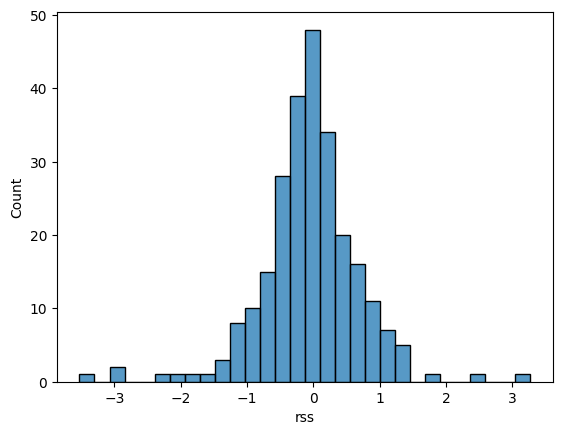

In [114]:
sns.histplot(data=aval,x='rss')

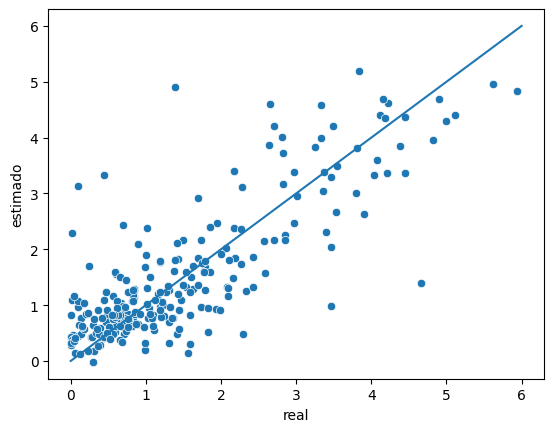

In [108]:
sns.scatterplot(data=aval,x='real',y='estimado')
plt.plot([0,6],[0,6])

<AxesSubplot: xlabel='real', ylabel='rss'>

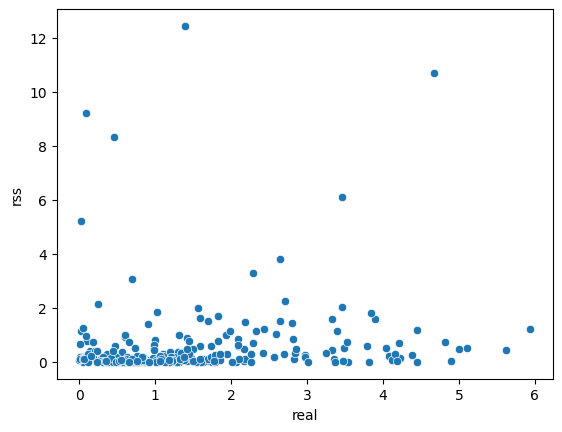

In [111]:
sns.scatterplot(data=aval,x='real',y='rss')

In [1]:
sns.scatterplot(data=aval,x='real',y='percent')

NameError: name 'sns' is not defined